# Modelos de clasificación

En esta lección vamos a aprender a modelizar datos para la clasificación en categorías de manera predictiva, en concreto:

 - Definición modelos clasificación y diferencias con los de regresión
 - Árboles de decisión
 - Métricas de evaluación de modelos de clasificación, Matriz de confusión
 - Random Forest
 - Regresión logística
 - Modelos desbalanceados

## Classification Machine Learning models

Los modelos de clasificación tienen como objetivo predecir en qué grupo o clase debemos clasificar a un individuo. Es decir, la variable dependiente es **discreta**. A diferencia de los modelos de regresión cuyo objetivo era predecir el valor exacto, ya que su variable dependiente era **continua**

Las variables independientes pueden ser tanto continuas como discretas.

En los modelos de clasificación las métricas usadas para calcular cómo de bueno es nuestro modelo se basan en contabilizar cuántos individuos han sido bien o mal clasificados en cada una de las clases (Accuracy, Precisión, Potencia, F-Score, sensibilidad y especificidad).

Los modelos de clasificación pueden ser **binomiales**, con dos categorías en la variable dependiente, o **multinomiales**, con 3 ó más grupos en la variable dependiente.

Existen multitud de modelos diferentes para clasificar individuos, entre ellos Árboles de decisión, Regresión Logística...



### Similarities and differences between Regression and Classification models

Similarities, both methodologies: 

 - Are types of machine learning models used for making predictions based on data
 - Have one or more independent variables and one dependent variable, so they are supervised learning
 - Require data cleaning and feature engineering
 - Independent variables can be categorical or continuous
 - Categorical variables must be dummy
 - They are trained using a train dataset and validated through a test dataset
 - Continuous features must be standardized
 
 
Differences:

 - Type of prediction task. Predictive models aim to predict a continuous numerical dependent variable, while classification models focus on assigning data points to discrete categories or classes.
 - Accuracy metrics. Predictive models reduce distances between prediction and actual values. Classification models measures how many instances are well or wrongly classified



## Árboles de decisión

https://www.youtube.com/watch?v=_L39rN6gz7Y

Es un sistema de modelado de datos que divide y subdivide el dataframe varias veces, en función de cómo discriminan las clases de la variable dependiente. 

In [ ]:
#!pip install -U imbalanced-learn

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set()
from collections import Counter

from scipy.special import expit

from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score
from sklearn import tree

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm
import statsmodels.formula.api as smf

#!pip install scikit-learn==0.20.0
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss

from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

In [4]:
aprende = pd.read_csv('../Data/Modelos ML/aprende.txt', sep = ';')
aprende

,id,escucha,comparte_pantalla,aprende
0,1,1,1,1
1,2,1,0,0
2,3,1,1,1
3,4,1,0,0
4,5,1,1,1
5,6,0,0,0
6,7,1,1,1
7,8,0,0,0
8,9,1,1,1
9,10,0,0,0


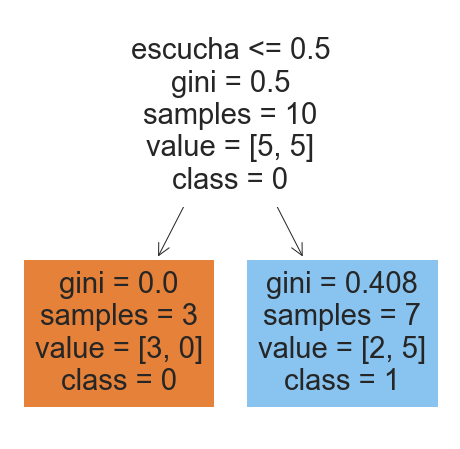

In [ ]:
classifier_DT = tree.DecisionTreeClassifier(max_depth = 3)
classifier_DT = classifier_DT.fit(aprende[['escucha']], aprende['aprende'])

fig = plt.figure(figsize=(8,8))
_ = tree.plot_tree(classifier_DT, 
                   feature_names=['escucha'],  
                   class_names=np.unique(aprende['aprende']).astype(str),
                   filled=True)

Hemos construido un árbol usando como variable clasificadora **escucha**, vemos los resultados:

En el **nodo raíz**, el primero de más arriba, tenemos que:

 - Va a hacer una división en torno al escucha <= 0.5, es decir, como la variable escucha toma 0 y 1, los ceros van a la izquierda y los unos a la derecha
 - que de todas las observaciones el 50% corresponden a cada una de las clases (Gini)
 - Tenemos 10 observaciones
 - 5 alumnos son aprende = 0 (No) y otros 5 son aprende = 1 (Sí)


En los **nodos del segundo nivel** tenemos que:

 - 3 observaciones van para un lado y 7 para el otro
 - en el de la izda 3 pertenecen a la clase 0, y ninguno a la clase 1. Tenemos una impureza de 0 (Gini)
 - en el de la drcha tenemos 2 pertenecientes  a la clase 0 y 5 a la clase 1. Impureza = 0.408
 - Como tal, los 3 estudiantes del nodo izquierdo serán clasificados como 0 (No aprenden), y los 7 de la derecha serán clasificados como 1 (Sí aprenden)
 
Conclusión, de los alumnos que no escuchan todos ellos no aprenden, pero de los que sí escuchan la clasificación no es tan buena, ya que se dirá que aprenden los 7, pero 2 de ellos no lo habrán hecho


Probamos ahora con la variable **comparte_pantalla**, a ver qué tal clasifica

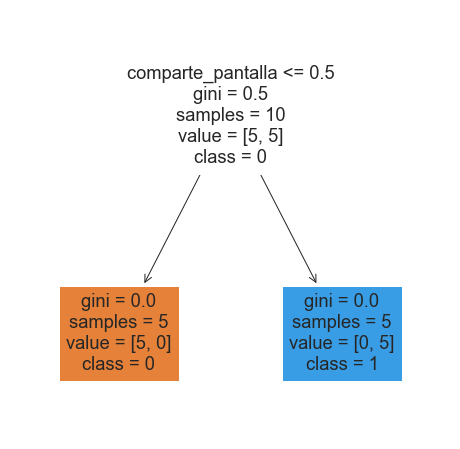

In [ ]:
classifier_DT = tree.DecisionTreeClassifier(max_depth = 3)
classifier_DT = classifier_DT.fit(aprende[['comparte_pantalla']], aprende['aprende'])

fig = plt.figure(figsize=(8,8))
_ = tree.plot_tree(classifier_DT, 
                   feature_names=['comparte_pantalla'],  
                   class_names=np.unique(aprende['aprende']).astype(str),
                   filled=True)

El nodo raíz es similar al anterior, ya que es el inicial

- Ambos nodos tienen impureza cero, es decir, separan perfectamente a los alumnos que aprenden de los que no aprenden
- La variable comparte_pantalla podemos considerarla una buena variable predictora de aprende.

Conclusión los alumnos que **comparten pantalla y escriben código a diario sí aprenden**, los que no lo hacen no aprenden

## Impureza de Gini y Entropía

*No confundir con el coeficiente de GINI

Gini es el indicador que nos dice cómo de buena o mala es la división que hacen los árboles de decisión. 

Esta división es por líneas, por individuos de nuestro dataset. Se hace a partir de una variable. Si nuestras observaciones en dicha variable toman un valor mayor que el punto de corte que estamos utilizando van hacia una rama del árbol de decisión, si es menor van hacia la otra.

Lo que nos indica Gini es cómo de mezcladas están las clases de la variable dependiente usando esa división. Gini toma valores entre 0 y 0.5, cuanto más bajo mejor discrimina.

Otra forma de verlo es considerando el Gini como un **índice de impureza**, cuanto más bajo más puro, siendo que cero significa que todas las observaciones que caen en cada una de las ramas son de la misma catagoría de la variable dependiente. Cuando Gini es próximo a 0.5 quiere decir que en esa rama tenemos 50/50 de la variable target.


Gini es calculado para todas las variables al inicio de cada nivel del árbol, la que tenga el valor más pequeño será la variable a usar como divisora de los datos

$$Gini(t) = 1 - \sum_{i=1}^{C} p_i^2$$

Donde:

- t : nodo actual del árbol
- C : número total de clases
-  $p_i$: proporción de elementos de la clase \( i \) en el nodo \( t \)



La **entropía** mide la cantidad de incertidumbre o desorden en un nodo.
- Entropía = 0: el nodo es puro (todos los datos pertenecen a una sola clase).
- Máxima entropía: cuando las clases están perfectamente balanceadas. Toma el máximo en 1 (Para dos clases)

$$Entropy(t) = - \sum_{i=1}^{C} p_i \log_2(p_i)$$




In [13]:
stroke = pd.read_csv('../../../Data/Modelos ML/Stroke.txt', sep = ';')
stroke.head()

,Id,Blood Pressure,Obesity,Sex,Stroke
0,1,H,Y,M,N
1,2,L,Y,M,Y
2,3,H,N,F,Y
3,4,N,Y,F,Y
4,5,H,Y,F,Y


In [19]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              130 non-null    int64 
 1   Blood Pressure  130 non-null    object
 2   Obesity         130 non-null    object
 3   Sex             130 non-null    object
 4   Stroke          130 non-null    object
 5   Blood2          130 non-null    int64 
 6   obesity2        130 non-null    int64 
 7   sex2            130 non-null    int64 
 8   stroke_attack   130 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 9.3+ KB


In [14]:
# label encoder custom

blood={'H': 0, 'N': 1, 'L': 2}  
obesity={'Y': 1, 'N': 0}  
sex={'M': 1, 'F': 0}  
stroke_attack={'Y': 1, 'N': 0} 

def encode(dic, x):   
    return dic[x]    

stroke['Blood2']=stroke['Blood Pressure'].apply(lambda x: blood[x])
stroke['obesity2']=stroke['Obesity'].apply(lambda x: obesity[x])
stroke['sex2']=stroke['Sex'].apply(lambda x: sex[x])
stroke['stroke_attack']=stroke['Stroke'].apply(lambda x: stroke_attack[x])

stroke.head()

,Id,Blood Pressure,Obesity,Sex,Stroke,Blood2,obesity2,sex2,stroke_attack
0,1,H,Y,M,N,0,1,1,0
1,2,L,Y,M,Y,2,1,1,1
2,3,H,N,F,Y,0,0,0,1
3,4,N,Y,F,Y,1,1,0,1
4,5,H,Y,F,Y,0,1,0,1


In [15]:
X_train, X_test, y_train, y_test = train_test_split(stroke[['Blood2','obesity2','sex2']], 
                                                    stroke['stroke_attack'], train_size = 0.8, random_state = 0)


In [16]:
print(X_train.shape)
print(X_test.shape)

(104, 3)
(26, 3)


In [17]:
print(X_train.groupby('Blood2')['Blood2'].count())
print(X_train.groupby('obesity2')['obesity2'].count())
print(X_train.groupby('sex2')['sex2'].count())

Blood2
0    31
1    40
2    33
Name: Blood2, dtype: int64
obesity2
0    51
1    53
Name: obesity2, dtype: int64
sex2
0    56
1    48
Name: sex2, dtype: int64


In [18]:
classifier_DT = tree.DecisionTreeClassifier(max_depth = 3)
classifier_DT = classifier_DT.fit(X_train, y_train)
classifier_DT.feature_importances_

array([0.68510434, 0.30753542, 0.00736024])

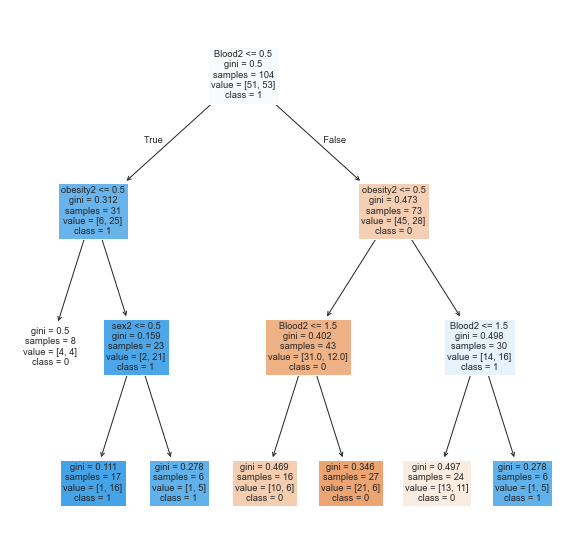

In [19]:
fig = plt.figure(figsize=(10,10))
_ = tree.plot_tree(classifier_DT, 
                   feature_names=['Blood2','obesity2','sex2'],  
                   class_names=np.unique(y_test).astype(str),
                   filled=True)

In [ ]:
classifier_DT.predict(X_test)


array([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 1, 1], dtype=int64)

In [28]:
print("Train set score (Accuracy) =", classifier_DT.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", classifier_DT.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, classifier_DT.predict(X_test))
print(tabulate(conf_mat,headers = ['pred Stroke No','pred Stroke Yes'], showindex = ['real Stroke No','real Stroke Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, classifier_DT.predict(X_test)))

Train set score (Accuracy) = 0.7115
Test set score (Accuracy) = 0.5769
╒═════════════════╤══════════════════╤═══════════════════╕
│                 │   pred Stroke No │   pred Stroke Yes │
╞═════════════════╪══════════════════╪═══════════════════╡
│ real Stroke No  │               11 │                 0 │
├─────────────────┼──────────────────┼───────────────────┤
│ real Stroke Yes │               11 │                 4 │
╘═════════════════╧══════════════════╧═══════════════════╛
              precision    recall  f1-score   support

           0       0.50      1.00      0.67        11
           1       1.00      0.27      0.42        15

    accuracy                           0.58        26
   macro avg       0.75      0.63      0.54        26
weighted avg       0.79      0.58      0.52        26



In [ ]:
prec=7/(7+5)
pot = 7/(4+7)

fscore = 2*(prec*pot)/(prec+pot)
fscore

0.6086956521739131

## Matriz de confusión

https://www.youtube.com/watch?v=Kdsp6soqA7o


La matriz de confusión resume todos los casos de nuestra prueba de validación, indicando cuántos fueron bien y mal clasificados, y también nos permite analizar si nuestro modelo clasifica bien para cada una de las categorías.


In [ ]:
print(tabulate([['TN',  'FP'],[ 'FN',  'TP']],headers = ['pred -','pred +'], showindex = ['real -','real +'], tablefmt = 'fancy_grid'))


╒════════╤══════════╤══════════╕
│        │ pred -   │ pred +   │
╞════════╪══════════╪══════════╡
│ real - │ TN       │ FP       │
├────────┼──────────┼──────────┤
│ real + │ FN       │ TP       │
╘════════╧══════════╧══════════╛


## Métricas de eficiencia del modelo de clasificación

https://medium.com/analytics-vidhya/what-is-a-confusion-matrix-d1c0f8feda5#:~:text=A%20confusion%20matrix%20is%20a%20tabular%20summary%20of,performance%20metrics%20like%20accuracy%2C%20precision%2C%20recall%2C%20and%20F1-score.

### Accuracy

Es la proporción de observaciones clasificadas correctamente

$$Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$$

Es el indicador más general y en el primero en el que tenemos que fijarnos

### Precisión

Es la proporción de clasificaciones positivas correctas sobre el total de clasificaciones positivas.
De todos los clasificados como 1, ¿Cuántos realmente lo eran?

$$Precision = \frac{TP}{TP + FP}$$

Este indicador queremos optimizarlo cuando nos interesa que las predicciones de una de las clases sea especialmente correcta, sin importarnos errar en la otra.

Por ejemplo, en la clasificación de los email Spam, 

### Potencia (Recall)

Es la proporción de verdaderos positivos clasificados como tal.
De todos los positivos, ¿Cuántos mi modelo ha clasificado como tal?

$$Potencia = \frac{TP}{TP + FN}$$

Este indicador lo optimizamos cuando una clase es especialmente sensible y no queremos dejar sin clasificar correctamente ninguno de sus individuos


### F-Score

Es una métrica que combina la Precisión y la Potencia

$$F-Score = \frac{2 * (Precision * Recall)}{(Precision + Recall)}$$

Nos permite calibrar un modelo teniendo en cuenta tanto la precisión como la potencia

## Cuándo optimizar precisión o potencia

En modelos de detección de enfermedades, como cuando se hacen **pruebas de diagnóstico**, bajo ningún concepto quieres clasificar a un paciente como no-enfermo, es preferible clasificar un sano como enfermo. Es decir, queremos reducir a toda costa el ratio de **Falsos negativos**. Esto se consigue **optimizando la Potencia**

En un modelo de **detección de spam** sería muy perjudicial dar un Falso positivo, es decir, marcar un email como spam cuando realmente es importante. Más vale que se cuele algún spam en la bandeja de entrada principal que al revés. Esto se consigue **optimizando la precisión**

En la práctica es muy importante entender bien el problema que se está intentando resolver/clasificar, y a partir de ahí buscar qué métrica se quiere analizar. 

La accuracy nos da una visión general que es buena e importante, pero no suficiente, **siempre se deben analizar varias de las métricas de las que disponemos**

## Random Forest

https://www.youtube.com/watch?v=J4Wdy0Wc_xQ

https://www.quantstart.com/articles/bootstrap-aggregation-random-forests-and-boosted-trees/


El algoritmo **Random Forest**, como su propio nombre indica, utiliza un conjunto de árboles para clasificar las observaciones. 

La idea es generar **varios árboles** (varios modelos), pero cuando tenemos un nuevo individuo y queremos clasificarlo, con qué árbol nos quedamos? Cuál es la clasificación correcta?

El nuevo individuo será pasado por todos los árboles que conforman el bosque, cada uno de ellos dará un veredicto y clasificará esta nueva observación como clase 1 ó 0. Después se hará una **votación**, la clase que más haya sido escogida por los árboles en su conjunto será la decisión final del algoritmo.


Por otro lado se le llama **Random** porque vamos a seleccionar en cada nivel de cada árbol un conjunto de variables a testar/introducir aleatoriamente (**Feature Bagging**).

También serán seleccionadas aleatoriamente una serie de observaciones, con reemplazamiento, o sea habrá posiblemente observaciones en el conjunto de entrenamiento que salgan repetidas y otras que no salgan. Esto se hace para aumentar el conjunto de entrenamiento.

https://immune.institute/blog/metodos-de-bagging-y-de-boosting-diferencia/

![image](../assets/Random_Forest.png)

In [20]:
dolphins = pd.read_csv('../../../Data/Modelos ML/Dolphnis.txt', sep = ';')
dolphins.head(3)

,Id,Length,Gills,Beak,Teeth,Dolphin
0,1,3,Y,Y,F,Y
1,2,3,N,N,F,Y
2,3,3,N,N,F,Y


In [21]:
dolphins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       271 non-null    int64 
 1   Length   271 non-null    int64 
 2   Gills    271 non-null    object
 3   Beak     271 non-null    object
 4   Teeth    271 non-null    object
 5   Dolphin  271 non-null    object
dtypes: int64(2), object(4)
memory usage: 12.8+ KB


In [22]:
Gills={'Y': 1, 'N': 0}  
Beak={'Y': 1, 'N': 0}  
Teeth={'M': 1, 'F': 0}  
Dolphin={'Y': 1, 'N': 0} 

def encode(dic, x):   
    return dic[x]    

dolphins['Gills2']=dolphins['Gills'].apply(lambda x: Gills[x])
dolphins['Beak2']=dolphins['Beak'].apply(lambda x: Beak[x])
dolphins['Teeth2']=dolphins['Teeth'].apply(lambda x: Teeth[x])
dolphins['Dolphin2']=dolphins['Dolphin'].apply(lambda x: Dolphin[x])
dolphins

,Id,Length,Gills,Beak,Teeth,Dolphin,Gills2,Beak2,Teeth2,Dolphin2
0,1,3,Y,Y,F,Y,1,1,0,1
1,2,3,N,N,F,Y,0,0,0,1
2,3,3,N,N,F,Y,0,0,0,1
3,4,3,Y,Y,F,Y,1,1,0,1
4,5,3,N,Y,F,Y,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...
266,267,3,Y,Y,F,Y,1,1,0,1
267,268,4,Y,N,F,Y,1,0,0,1
268,269,3,Y,Y,F,Y,1,1,0,1
269,270,4,Y,Y,F,Y,1,1,0,1


In [23]:
dolphins.groupby('Dolphin2')['Dolphin2'].count()

Dolphin2
0    117
1    154
Name: Dolphin2, dtype: int64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(dolphins[['Gills2','Beak2','Teeth2','Length']], 
                                                    dolphins['Dolphin2'], train_size = 0.60, random_state = 0)
X_test.shape

(109, 4)

In [25]:
rf_clf = RandomForestClassifier(n_estimators = 3, criterion ='gini') #  criterion ='entropy' 
rf_clf.fit(X_train,y_train)

RandomForestClassifier(n_estimators=3)

In [33]:
y_predict = rf_clf.predict(X_test)
y_predict

array([1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0],
      dtype=int64)

In [34]:
y_test

64     1
136    1
223    0
129    0
254    1
      ..
252    0
189    0
249    0
40     0
13     1
Name: Dolphin2, Length: 109, dtype: int64

In [35]:
df_y_test = pd.DataFrame(y_test)
df_y_test['pred'] = y_predict
df_y_test

,Dolphin2,pred
64,1,1
136,1,1
223,0,0
129,0,1
254,1,1
...,...,...
252,0,0
189,0,0
249,0,0
40,0,1


In [43]:
print("Train set score (Accuracy) =", rf_clf.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", rf_clf.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, rf_clf.predict(X_test))
print(tabulate(conf_mat,headers = ['pred Dolphin No','pred Dolphin Yes'], showindex = ['real Dolphin No','real Dolphin Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, rf_clf.predict(X_test)))

Train set score (Accuracy) = 0.821
Test set score (Accuracy) = 0.8165
╒══════════════════╤═══════════════════╤════════════════════╕
│                  │   pred Dolphin No │   pred Dolphin Yes │
╞══════════════════╪═══════════════════╪════════════════════╡
│ real Dolphin No  │                42 │                  8 │
├──────────────────┼───────────────────┼────────────────────┤
│ real Dolphin Yes │                12 │                 47 │
╘══════════════════╧═══════════════════╧════════════════════╛
              precision    recall  f1-score   support

           0       0.78      0.84      0.81        50
           1       0.85      0.80      0.82        59

    accuracy                           0.82       109
   macro avg       0.82      0.82      0.82       109
weighted avg       0.82      0.82      0.82       109



## Responde Verdadero o Falso

 - El 81% de los animales validados han sido correctamente clasificados
 - De todos los delfines intriducidos en el modelo el 85% han sido clasificados como delfines
 - De todas los animales clasificados por el modelo como delfines, el 85% realmente eran delfines

## Regresión Logística

https://www.youtube.com/watch?v=yIYKR4sgzI8&list=PLblh5JKOoLUKxzEP5HA2d-Li7IJkHfXSe

https://es.wikipedia.org/wiki/Regresi%C3%B3n_log%C3%ADstica

https://datascientest.com/es/que-es-la-regresion-logistica

La regresión logística es un modelo estadístico para estudiar las relaciones entre un conjunto de **variables X** y una **variable cualitativa Y**. Se trata de un modelo lineal generalizado que utiliza una función logística como función de enlace.

Un modelo de regresión logística permite predecir la **probabilidad de que ocurra un evento** (valor de 1) o no (valor de 0) a partir de la optimización de los coeficientes de regresión. Este resultado siempre varía entre 0 y 1. Cuando el valor predicho supera un umbral(normalmente 0.5), es probable que ocurra el evento, mientras que cuando ese valor está por debajo del mismo umbral, no es así.

También se puede definir como una función que busca predecir la clase a la que pertenece un individuo del cual sólo conocemos parte de su información, la relativa a sus variables independientes.



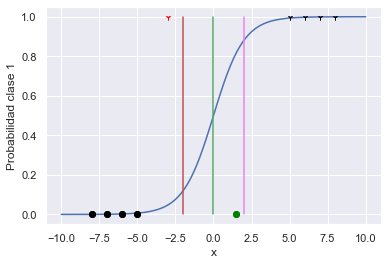

In [11]:
#define range of x-values
x = np.linspace(-10, 10, 100)

#calculate sigmoid function for each x-value
y = expit(x)
  
#create plot
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('Probabilidad clase 1')

plt.plot([-2,-2], [0, 1], color='r')
plt.plot([0,0], [0, 1], color='g')
plt.plot([2,2], [0, 1], color='violet')

plt.plot([-5,-5], [0, 0], marker = 'o', color='black')
plt.plot([-6,-6], [0, 0], marker = 'o', color='black')
plt.plot([-7,-7], [0, 0], marker = 'o', color='black')
plt.plot([-8,-8], [0, 0], marker = 'o', color='black')
plt.plot([-3,-3], [1, 1], marker = '1', color='red')

plt.plot([1.5,1.5], [0, 0], marker = 'o', color='green')
plt.plot([5,5], [1, 1], marker = '1', color='black')
plt.plot([6,6], [1, 1], marker = '1', color='black')
plt.plot([7,7], [1, 1], marker = '1', color='black')
plt.plot([8,8], [1, 1], marker = '1', color='black')

#display plot
plt.show()

Cuando la variable independiente X toma el valor -2, la probabilidad de pertencer a la clase 1 es casi igual a 0. Cuando X toma el valor 2 la probabilidad del individuo pertenecer a la clase 1 es muy alta.

El punto rojo tiene características de la clase 0, por eso su probabilidad de ser clase 1 es tan baja, no obstante en la realidad es clase 1, en definitiva estaría mal clasificado para cualquier punto de corte propuesto. El punto verde estaría solo bien clasificado usando el punto de corte morado. Contrariamente al rojo, tiene características de clase 1 a pesar de ser clase 0.


La regresión logística se ajusta los datos a través de una función sigmoide. 

Para definir qué función sigmoide es la más idónea, vamos a tratar de optimizar los coeficientes Beta

$$P(y = 1 \mid \mathbf{x}) = \frac{1}{1 + e^{-\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots + \beta_n }}$$

### Regresion logística con Python

https://realpython.com/logistic-regression-python/

In [45]:
df = pd.read_csv('../Data/Modelos ML/Spotify.csv')
df.columns

Index(['id', 'track', 'artist', 'uri', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature',
       'chorus_hit', 'sections', 'decade', 'hit'],
      dtype='object')

In [46]:
df.groupby('hit')['hit'].count()

hit
0    20333
1    20496
Name: hit, dtype: int64

In [47]:
X = df.drop(columns='hit').drop(columns=['id','track','artist','uri'])
y = df['hit']

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X[['danceability','energy','loudness']], y, train_size = 0.8, random_state=42)


In [51]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

LogisticRegression()

In [52]:
model_LR.intercept_

array([0.19896023])

In [53]:
model_LR.coef_

array([[ 3.91858158, -1.23590741,  0.15967818]])

In [54]:
model_LR.predict(X_train)

array([1, 1, 1, ..., 0, 0, 0])

In [55]:
print("Train set score (Accuracy) =", model_LR.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", model_LR.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR.predict(X_test))
print(tabulate(conf_mat,headers = ['pred Hit No','pred Hit Yes'], showindex = ['real Hit No','real Hit Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR.predict(X_test)))

Train set score (Accuracy) = 0.6699
Test set score (Accuracy) = 0.6754
╒══════════════╤═══════════════╤════════════════╕
│              │   pred Hit No │   pred Hit Yes │
╞══════════════╪═══════════════╪════════════════╡
│ real Hit No  │          2584 │           1497 │
├──────────────┼───────────────┼────────────────┤
│ real Hit Yes │          1154 │           2931 │
╘══════════════╧═══════════════╧════════════════╛
              precision    recall  f1-score   support

           0       0.69      0.63      0.66      4081
           1       0.66      0.72      0.69      4085

    accuracy                           0.68      8166
   macro avg       0.68      0.68      0.67      8166
weighted avg       0.68      0.68      0.67      8166



## Otro ejemplo

In [46]:
cancer = pd.read_csv('../../../Data/Modelos ML/breast-cancer.csv', sep = ';')
cancer

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [75]:
cancer['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [47]:
diagnosis={'M': 1, 'B': 0} 

def encode(dic, x):   
    return dic[x]    

cancer['diagnosis2']=cancer['diagnosis'].apply(lambda x: diagnosis[x])

In [48]:
X = cancer.drop(columns=['id','diagnosis'])
X = cancer[['smoothness_mean','compactness_mean']]
y = cancer['diagnosis2']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)


In [49]:
y_test

204    0
70     1
131    1
431    0
540    0
      ..
486    0
75     1
249    0
238    0
265    1
Name: diagnosis2, Length: 114, dtype: int64

In [71]:
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

print(model_LR.intercept_)
print(model_LR.coef_)

[-1.15717582]
[[0.85635674 5.21828998]]


In [ ]:
model_LR.predict(X_train)[0:10]

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [72]:
print("Train set score (Accuracy) =", model_LR.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", model_LR.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR.predict(X_test))
print(tabulate(conf_mat,headers = ['pred cancer No','pred cancer Yes'], showindex = ['real cancer No','real cancer Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR.predict(X_test)))

Train set score (Accuracy) = 0.6681
Test set score (Accuracy) = 0.6842
╒═════════════════╤══════════════════╤═══════════════════╕
│                 │   pred cancer No │   pred cancer Yes │
╞═════════════════╪══════════════════╪═══════════════════╡
│ real cancer No  │               71 │                 0 │
├─────────────────┼──────────────────┼───────────────────┤
│ real cancer Yes │               36 │                 7 │
╘═════════════════╧══════════════════╧═══════════════════╛
              precision    recall  f1-score   support

           0       0.66      1.00      0.80        71
           1       1.00      0.16      0.28        43

    accuracy                           0.68       114
   macro avg       0.83      0.58      0.54       114
weighted avg       0.79      0.68      0.60       114



In [76]:
cancer.groupby('diagnosis2')['diagnosis2'].count()

diagnosis2
0    357
1    212
Name: diagnosis2, dtype: int64

<Axes: xlabel='diagnosis2', ylabel='Count'>

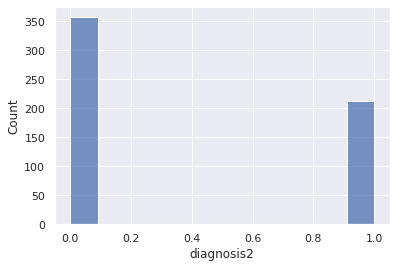

In [77]:
sns.histplot(cancer.diagnosis2)

## Modelos de clasificación desbalanceados

En el mundo real pocas son las ocasiones en las que las categorías de nuestra variable dependiente están balanceadas, esto quiere decir que la **variable dependiente no tiene la misma frecuencia en sus dos catagorías**.


Hay que prestar especial atención a esto ya que el modelo puede clasificar mal aparentando que lo hace bien. Como acabamos de ver, el algoritmo es muy listo y sabe que clasificando todo 0 va a tener una buena accuracy, así que "no se la juega"


Por eso es tan importante hacer un buen **análisis de datos y conocer bien la distribución de nuestras variables**

Existen varias formas de corregir esta situación de desbalanceo: oversampling y undersampling.

El **oversampling** consiste en repetir/duplicar observaciones de la clase menos frecuente hasta conseguir una proporción de al menos 40/60


El **undersampling** consiste en eliminar observaciones de la clase mayoritaria hasta igualar con la otra (al menos 40/60).

También se puede hacer una combinación de ambas.

Es importante tener en cuenta que solo aplicaremos la técnica de Oversampling o Undersampling a los **datos de entrenamiento**, los datos de test no se tocan.


Nuestro desbalanceo aquí es de un 30/70, pero es habitual encontrarse un 10/90 o incluso 1/99

Cómo solucionarlo??
https://medium.com/grabngoinfo/four-oversampling-and-under-sampling-methods-for-imbalanced-classification-using-python-7304aedf9037

### Over Sampling

- Random Oversampling: Con esta técnica el algoritmo genera datos nuevos de forma aleatoria basándose en los datos que le pasamos, hasta igualar ambas clases.


In [50]:
ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)


In [51]:
y_train_ros.value_counts()

diagnosis2
0    286
1    286
Name: count, dtype: int64

<AxesSubplot:xlabel='diagnosis2', ylabel='Count'>

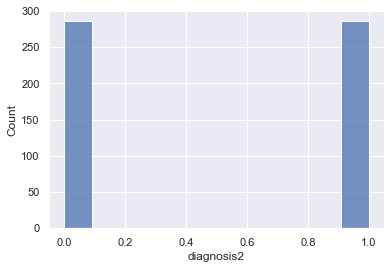

In [ ]:
sns.histplot(y_train_ros)

In [ ]:
model_LR_ros = LogisticRegression()
model_LR_ros.fit(X_train_ros, y_train_ros)

print(model_LR_ros.intercept_)
print(model_LR_ros.coef_)

[-0.80405137]
[[1.0444569  6.35140046]]


In [ ]:
print("Train set score (Accuracy) =", model_LR_ros.score(X_train, y_train).round(4))
print("Test set score (Accuracy) =", model_LR_ros.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR_ros.predict(X_test))
print(tabulate(conf_mat,headers = ['pred diagnosis B','pred diagnosis M'], showindex = ['real iagnosis B','real diagnosis M'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR_ros.predict(X_test)))

Train set score (Accuracy) = 0.7934
Test set score (Accuracy) = 0.7807
╒══════════════════╤════════════════════╤════════════════════╕
│                  │   pred diagnosis B │   pred diagnosis M │
╞══════════════════╪════════════════════╪════════════════════╡
│ real iagnosis B  │                 58 │                 13 │
├──────────────────┼────────────────────┼────────────────────┤
│ real diagnosis M │                 12 │                 31 │
╘══════════════════╧════════════════════╧════════════════════╛
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        71
           1       0.70      0.72      0.71        43

    accuracy                           0.78       114
   macro avg       0.77      0.77      0.77       114
weighted avg       0.78      0.78      0.78       114



### Oversampling SMOTE


SMOTE es una técnica de oversampling que genera ejemplos sintéticos de la clase minoritaria para equilibrar un conjunto de datos desbalanceado, en lugar de simplemente duplicar observaciones existentes.

Busca los k vecinos más cercanos para cada muestra minoritaria usando una métrica de distancia (por defecto, euclídea), calculada sobre todas las variables numéricas de X_train. Después, selecciona uno de esos vecinos al azar para a continuación generar un punto entre el original y el vecino.

SMOTE solo funciona con variables numéricas, si tienes variables categóricas debemos usar SMOTENC.

```python
# Índices (no nombres) de las columnas categóricas
categorical_features = [0, 3, 5]  # por ejemplo

smote_nc = SMOTENC(categorical_features=categorical_features, random_state=42)
X_train_sm, y_train_sm = smote_nc.fit_resample(X_train, y_train)
```

In [52]:
smote = SMOTE()

In [53]:
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [54]:
y_train_sm.value_counts()

diagnosis2
0    286
1    286
Name: count, dtype: int64

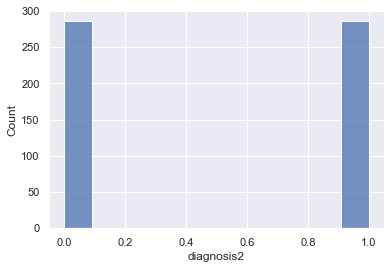

In [ ]:
sns.histplot(y_train_sm);

In [ ]:
model_LR_sm = LogisticRegression()
model_LR_sm.fit(X_train_sm, y_train_sm)

LogisticRegression()

In [ ]:
model_LR_sm.intercept_

array([-0.81459994])

In [ ]:
model_LR_sm.coef_

array([[1.01670075, 6.43290437]])

In [ ]:
model_LR_sm.predict(X_test)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1], dtype=int64)

In [ ]:
print("Train set score (Accuracy) =", model_LR_sm.score(X_train_sm, y_train_sm).round(4))
print("Test set score (Accuracy) =", model_LR_sm.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR_sm.predict(X_test))
print(tabulate(conf_mat, headers = ['pred diagnosis B','pred diagnosis M'], showindex = ['real iagnosis B','real diagnosis M'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR_sm.predict(X_test)))

Train set score (Accuracy) = 0.7867
Test set score (Accuracy) = 0.7807
╒════════════════════╤═════════════════════╤══════════════════════╕
│                    │   pred Purchased No │   pred Purchased Yes │
╞════════════════════╪═════════════════════╪══════════════════════╡
│ real Purchased No  │                  58 │                   13 │
├────────────────────┼─────────────────────┼──────────────────────┤
│ real Purchased Yes │                  12 │                   31 │
╘════════════════════╧═════════════════════╧══════════════════════╛
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        71
           1       0.70      0.72      0.71        43

    accuracy                           0.78       114
   macro avg       0.77      0.77      0.77       114
weighted avg       0.78      0.78      0.78       114



### Undersampling

Undersampling elimina aleatoriamente observaciones de la clase mayoritaria hasta igualar con la minoritaria


In [ ]:
# Randomly under sample the majority class
rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)

# Check the number of records after under sampling
print(sorted(Counter(y_train_rus).items()))

[(0, 169), (1, 169)]


In [ ]:
y_train_rus.value_counts()

0    169
1    169
Name: diagnosis2, dtype: int64

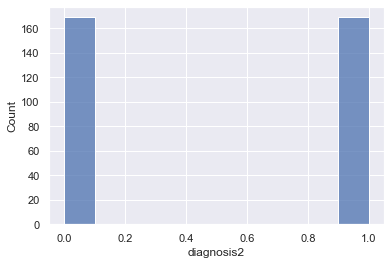

In [ ]:
sns.histplot(y_train_rus);

In [ ]:
model_LR_rus = LogisticRegression()
model_LR_rus.fit(X_train_rus, y_train_rus)

LogisticRegression()

In [ ]:
model_LR_rus.intercept_

array([-0.5577551])

In [ ]:
model_LR_rus.coef_

array([[0.70294376, 4.40107778]])

In [ ]:
model_LR_rus.predict(X_test)

array([0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1], dtype=int64)

In [ ]:
print("Train set score (Accuracy) =", model_LR_rus.score(X_train_rus, y_train_rus).round(4))
print("Test set score (Accuracy) =", model_LR_rus.score(X_test, y_test).round(4))

conf_mat = confusion_matrix(y_test, model_LR_rus.predict(X_test))
print(tabulate(conf_mat,headers = ['pred diagnosis B','pred diagnosis M'], showindex = ['real iagnosis B','real diagnosis M'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR_rus.predict(X_test)))

Train set score (Accuracy) = 0.7811
Test set score (Accuracy) = 0.7807
╒════════════════════╤═════════════════════╤══════════════════════╕
│                    │   pred Purchased No │   pred Purchased Yes │
╞════════════════════╪═════════════════════╪══════════════════════╡
│ real Purchased No  │                  58 │                   13 │
├────────────────────┼─────────────────────┼──────────────────────┤
│ real Purchased Yes │                  12 │                   31 │
╘════════════════════╧═════════════════════╧══════════════════════╛
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        71
           1       0.70      0.72      0.71        43

    accuracy                           0.78       114
   macro avg       0.77      0.77      0.77       114
weighted avg       0.78      0.78      0.78       114



## Rebalancear el peso de los errores

Otra opción es rebalancear el peso de la función de pérdida de manera que los errores de la clase minoritaria tengan mucho más impacto que los errores de la clase mayoritaria, sin alterar el dataset de entrenamiento. De esta forma a cada iteración en la búsqueda de los $\beta$ óptimos se corrige. La función de pérdida será pues:

$$\mathcal{L}(\theta) = - \frac{1}{N} \sum_{i=1}^N w_{y_i} \left[ y_i \log \hat{p}_i + (1 - y_i) \log (1 - \hat{p}_i) \right]$$

- $w_{y_i}$ es el peso asignado a la clase verdadera $y_i$, calculado como:

- $w_k = \frac{N}{K \times N_k}$

- $N $ es el número total de muestras
- $K $ es el número total de clases
- $N_k $ es el número de muestras de la clase \( k \)
- $\hat{p}_i = \sigma(\theta^T x_i) = \frac{1}{1 + e^{-\theta^T x_i}} $ es la probabilidad predicha para la clase 1

En Random Forest balanceamos antes de cada nodo el Gini:

$Gini(t) = 1 - \sum_{i=1}^{C} w_{y_i} p_i^2$


Usando la librería sklearn tenemos un paramétro que nos permite realizar esta acción `class_weight='balanced'`, donde balancea la función de pérdida de la siguiente manera


$w_i = \frac{n_{\text{clases}} \times n_{\text{samples}_i}}{n_{\text{samples}}}$

In [57]:
model_LR = LogisticRegression(class_weight='balanced')
model_LR.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [61]:
print("Train set score (Accuracy) =", model_LR.score(X_train, y_train))
print("Test set score (Accuracy) =", model_LR.score(X_test, y_test))

conf_mat = confusion_matrix(y_test, model_LR.predict(X_test))
print(tabulate(conf_mat,headers = ['pred cancer No','pred cancer Yes'], showindex = ['real cancer No','real cancer Yes'], tablefmt = 'fancy_grid'))

print(classification_report(y_test, model_LR.predict(X_test)))

Train set score (Accuracy) = 0.7912087912087912
Test set score (Accuracy) = 0.7807017543859649
╒═════════════════╤══════════════════╤═══════════════════╕
│                 │   pred cancer No │   pred cancer Yes │
╞═════════════════╪══════════════════╪═══════════════════╡
│ real cancer No  │               58 │                13 │
├─────────────────┼──────────────────┼───────────────────┤
│ real cancer Yes │               12 │                31 │
╘═════════════════╧══════════════════╧═══════════════════╛
              precision    recall  f1-score   support

           0       0.83      0.82      0.82        71
           1       0.70      0.72      0.71        43

    accuracy                           0.78       114
   macro avg       0.77      0.77      0.77       114
weighted avg       0.78      0.78      0.78       114

